In [1]:
%pylab inline

from easy_plot import easy_plot

import scipy.ndimage as ndi
from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft
import dphplotting as dplt
from dphutils import bin_ndarray, radial_profile

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 432x288 with 0 Axes>

## Apotome

The technology behind the [Zeiss Apotome](https://www.zeiss.com/microscopy/us/products/imaging-systems/apotome-2-for-biology.html) was described by [Neil](https://www.osapublishing.org/abstract.cfm?URI=ol-22-24-1905) and [Wilson](http://www.sciencedirect.com/science/article/pii/S0030401898002107) over 20 years ago. While the math in the papers is opaque and difficult to understand the result can be summarized as follows: the Apotome PSF is similar to a light sheet PSF where the width of the light sheet is similar to the axial resolution of microscope and the axial profile is proportional to $J_1(z) / z$. Looking at the second publication the magic all happens in equation 6 where the substitution $S_1(t_1) \sim \exp(j\nu t_1)$ is made (which I still don't understand). The result of this substitution is that the axial response of the system can be written as

$$
I_p(u) = |g(u, \nu)|
$$

Where $g$ is a weird hybrid OTF where the axial dimension is real space and the lateral dimension in k space and $u$ is the normalized axial dimension, $u = 8(\pi / \lambda) z \sin^2(\alpha / 2)$ and $\nu = f \lambda / NA$ where $NA = n \sin (\alpha)$ and $f$ is the actual frequency of the grid.

We can proceed with the simulation as before.

In [3]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=64,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 1

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.99 / oversample_factor
psf_params["size"] *= oversample_factor

In [4]:
# calculate 3D
psf_det = SheppardPSF(**psf_params).PSFi

### Weird OTF

In [5]:
otf_plot = easy_fft(psf_det, axes=(0,))
otf = easy_ifft(otf_plot)

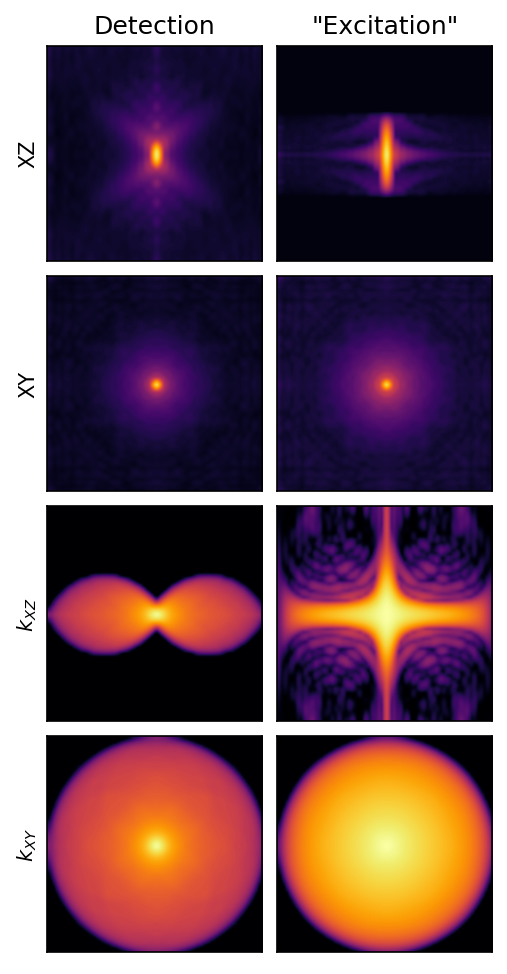

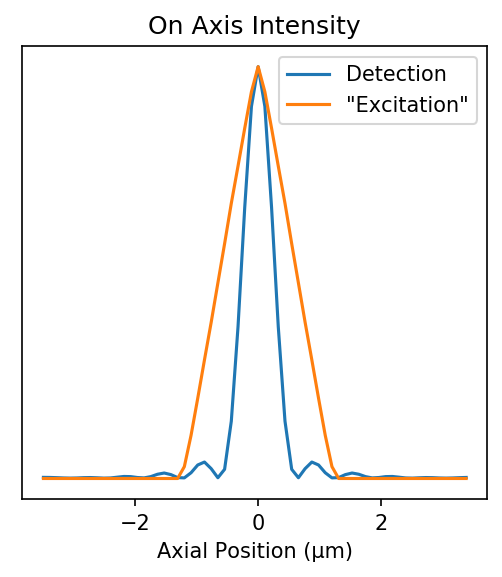

In [6]:
easy_plot((psf_det, otf_plot.real), ("Detection", '"Excitation"'), oversample_factor, res=psf_params["res"])

In [7]:
rotf = np.array([radial_profile(o)[0] for o in otf])
rotf /= rotf.max()
rotf = abs(rotf)

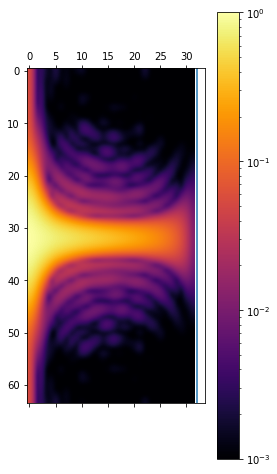

In [8]:
abbe_limit = int(np.rint(psf_params["size"] * psf_params["res"] / nyquist_sampling / 2))
matshow(np.fmax(1e-3, abs(rotf)[:, :(psf_params["size"] + 1)//2]), norm=mpl.colors.LogNorm(), interpolation="bicubic")
axvline(abbe_limit)
colorbar()

Maximum optical sectioning is at a frequency of half the abbe limit (an appeal to SIM will show that this is most effective at filling in the missing cone).

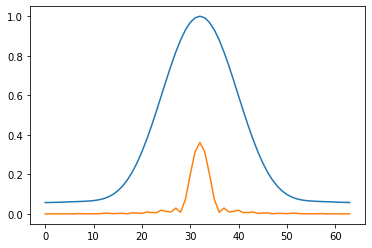

In [9]:
plot(rotf[:, :abbe_limit:abbe_limit//2])

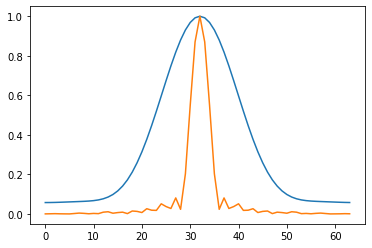

In [10]:
plot((rotf/rotf.max(0))[:, :abbe_limit:abbe_limit//2])

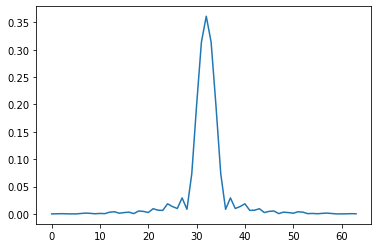

In [11]:
axial_profile = rotf[:, abbe_limit//2]
plot(axial_profile)

In [22]:
psf_apo = psf_det * axial_profile[:, None, None]

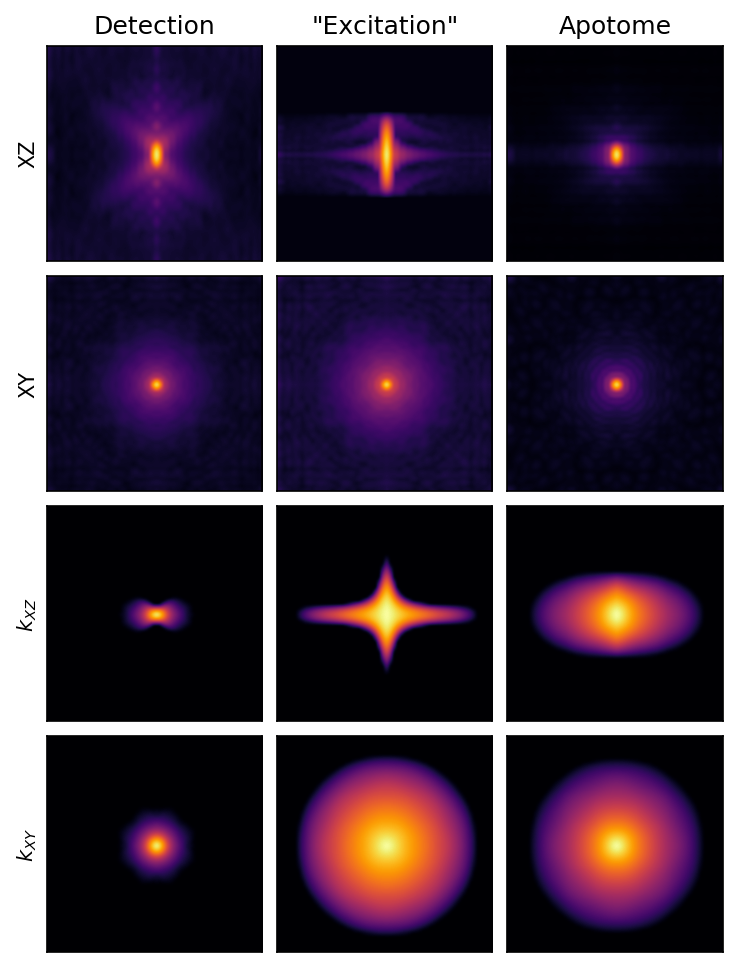

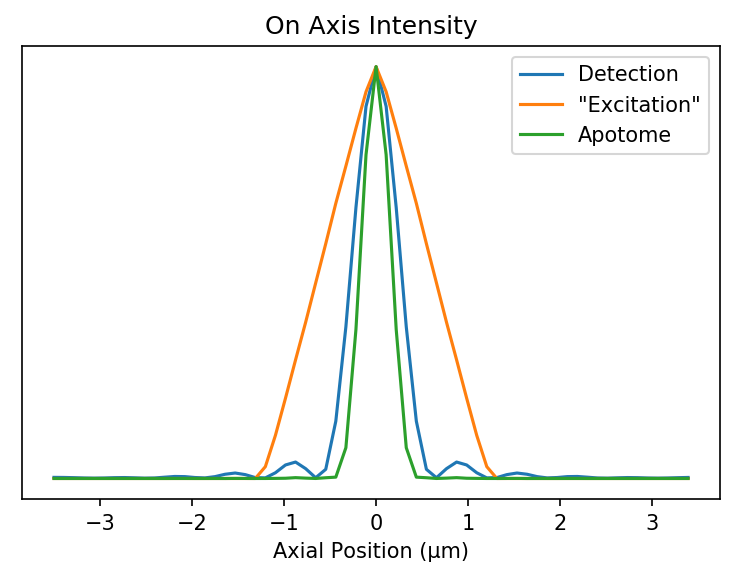

In [23]:
easy_plot((psf_det, otf_plot.real, psf_apo), ("Detection", '"Excitation"', "Apotome"),
          oversample_factor, psf_params["res"], vmin=1e-1)

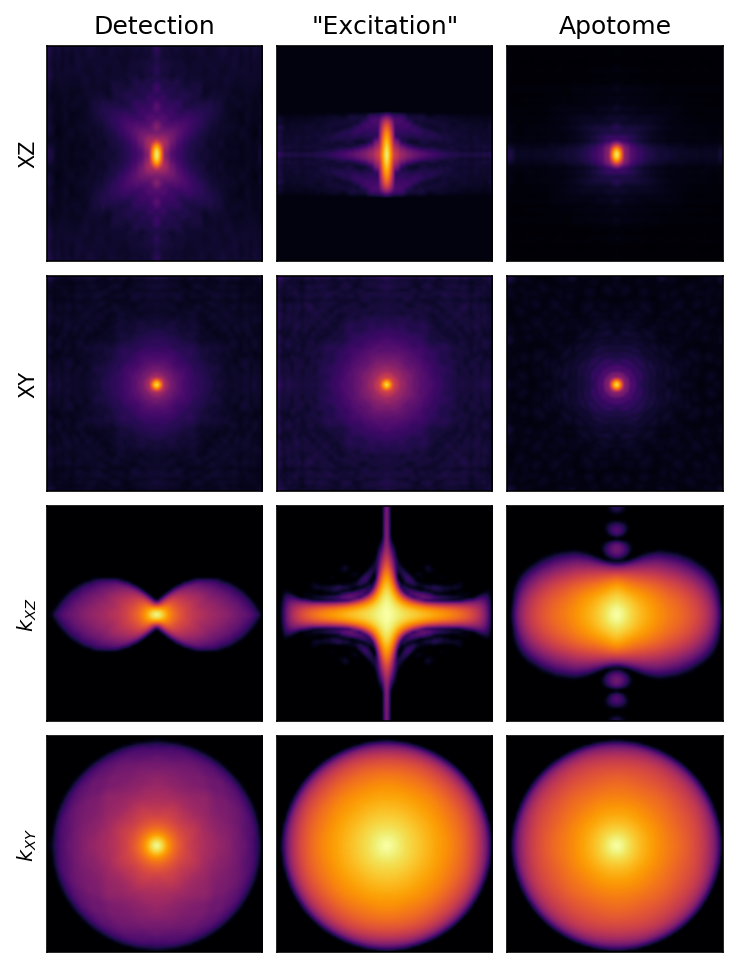

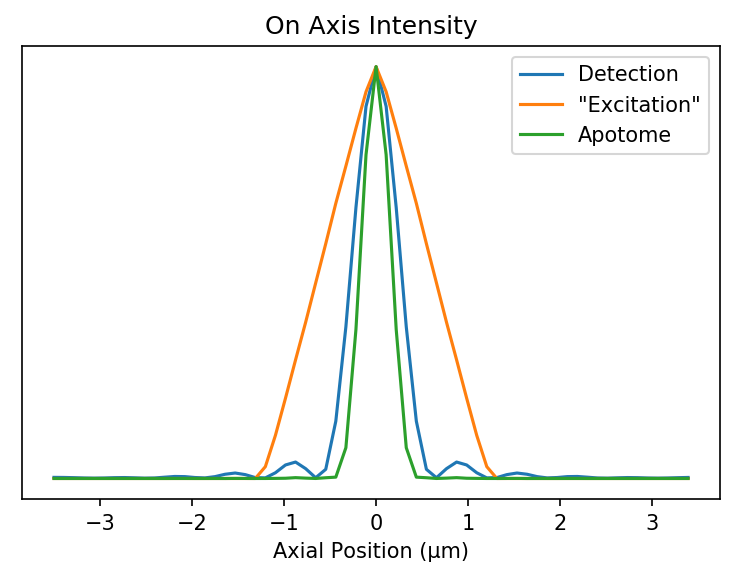

In [24]:
easy_plot((psf_det, otf_plot.real, psf_apo), ("Detection", '"Excitation"', "Apotome"),
          oversample_factor, psf_params["res"], vmin=1e-2)